my imports

In [4]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.data import AUTOTUNE


now im gonna load the dataset

In [5]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)

data augmentation

In [6]:
def preprocess(image, label):
    image = tf.image.resize(image, (128, 128))  # Resize to smaller dimensions
    image = image / 255.0  # Normalize
    return image, label

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(preprocess).batch(16).prefetch(AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.map(preprocess).batch(16).prefetch(AUTOTUNE)


at first i used the resnet50 but it kept crashing my session so i decided to use mobilenetv2 bc it reduces memory usage

In [7]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


шim gonna modify the final layers

In [8]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(100, activation='softmax')
])

im compiling it

In [9]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

finally training it

In [10]:
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=10
)


Epoch 1/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 736s 233ms/step - accuracy: 0.2295 - loss: 3.2690 - val_accuracy: 0.4501 - val_loss: 2.0678
Epoch 2/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 730s 230ms/step - accuracy: 0.3796 - loss: 2.3754 - val_accuracy: 0.4723 - val_loss: 1.9583
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 737s 228ms/step - accuracy: 0.4089 - loss: 2.2476 - val_accuracy: 0.4800 - val_loss: 1.9112
Epoch 4/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 708s 217ms/step - accuracy: 0.4229 - loss: 2.1741 - val_accuracy: 0.4783 - val_loss: 1.9253
Epoch 5/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 714s 228ms/step - accuracy: 0.4335 - loss: 2.1170 - val_accuracy: 0.4936 - val_loss: 1.9053
Epoch 6/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 740s 227ms/step - accuracy: 0.4485 - loss: 2.0571 - val_accuracy: 0.4912 - val_loss: 1.9109
Epoch 7/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 744s 228ms/step - accuracy: 0.4543 - loss: 2.0271 - val_accuracy: 0.4910 - val_loss: 1.9193
Epoch 8/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 742s 228ms/step - ac

im evaluating the model

In [11]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy:.2f}")


625/625 ━━━━━━━━━━━━━━━━━━━━ 117s 188ms/step - accuracy: 0.5014 - loss: 1.9483
Test Accuracy: 0.50


fine tuning

In [12]:
base_model.trainable = True
for layer in base_model.layers[:50]:  # Замораживаем первые 50 слоев
    layer.trainable = False

In [13]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



In [14]:
history_fine_tune = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=5
)


Epoch 1/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1573s 494ms/step - accuracy: 0.2203 - loss: 9.9515 - val_accuracy: 0.4698 - val_loss: 2.9872
Epoch 2/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1605s 502ms/step - accuracy: 0.3621 - loss: 2.8205 - val_accuracy: 0.5312 - val_loss: 1.8588
Epoch 3/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1576s 500ms/step - accuracy: 0.4354 - loss: 2.1828 - val_accuracy: 0.5683 - val_loss: 1.6836
Epoch 4/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1612s 509ms/step - accuracy: 0.4932 - loss: 1.8533 - val_accuracy: 0.5894 - val_loss: 1.5911
Epoch 5/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 1709s 531ms/step - accuracy: 0.5370 - loss: 1.6312 - val_accuracy: 0.6072 - val_loss: 1.5364


evaluating the model

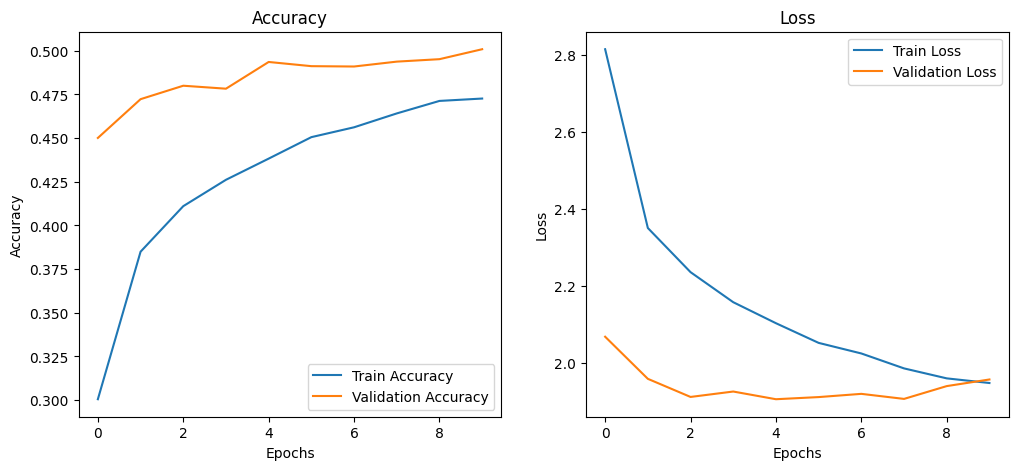

625/625 ━━━━━━━━━━━━━━━━━━━━ 112s 180ms/step - accuracy: 0.6052 - loss: 1.5490
Test Accuracy: 0.61


In [15]:
import matplotlib.pyplot as plt
import numpy as np
def plot_learning_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Отображаем графики
plot_learning_curves(history)

# 9. Оценка модели
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy:.2f}")


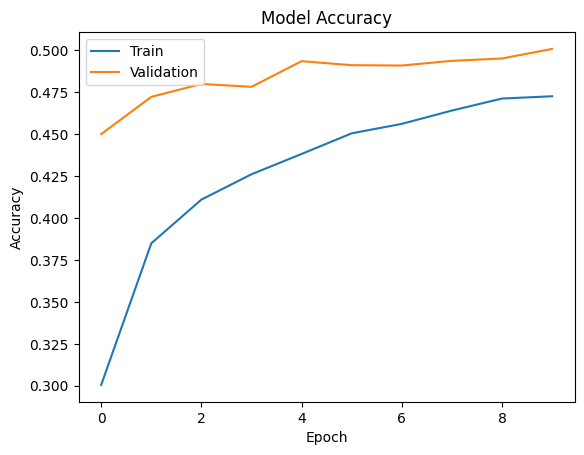

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


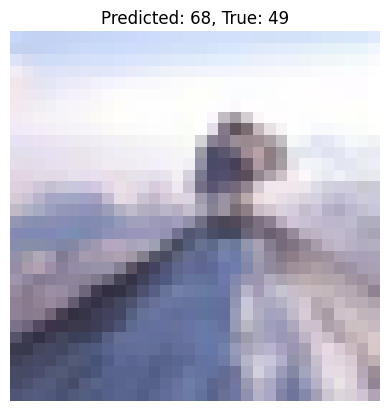

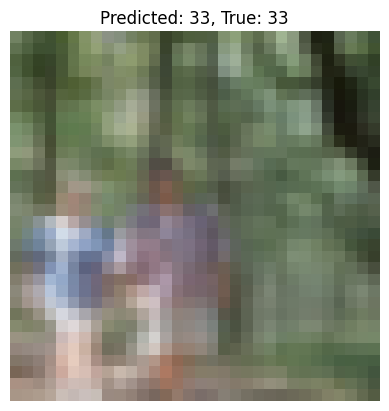

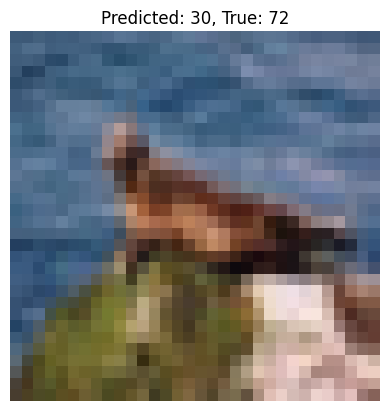

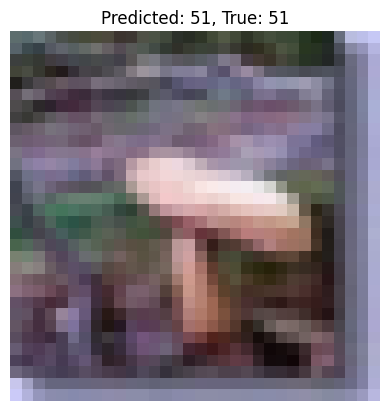

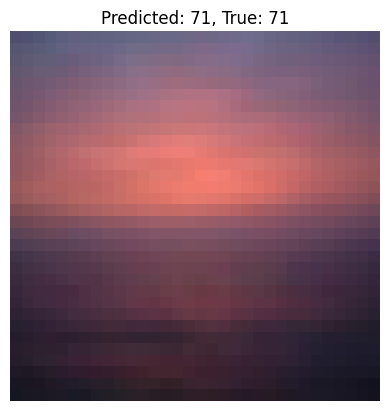

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Получение первых 5 изображений и предсказаний
x_test_sample = x_test[:5]
y_test_sample = y_test[:5]
# Resize to the original input shape of the model
x_test_sample_resized = tf.image.resize(x_test_sample, (128, 128)) / 255.0
predictions = model.predict(x_test_sample_resized)

for i in range(5):
    plt.imshow(x_test_sample[i])
    predicted_class = np.argmax(predictions[i])
    true_class = np.argmax(y_test_sample[i])
    plt.title(f"Predicted: {predicted_class}, True: {true_class}")
    plt.axis('off')
    plt.show()

625/625 ━━━━━━━━━━━━━━━━━━━━ 116s 186ms/step


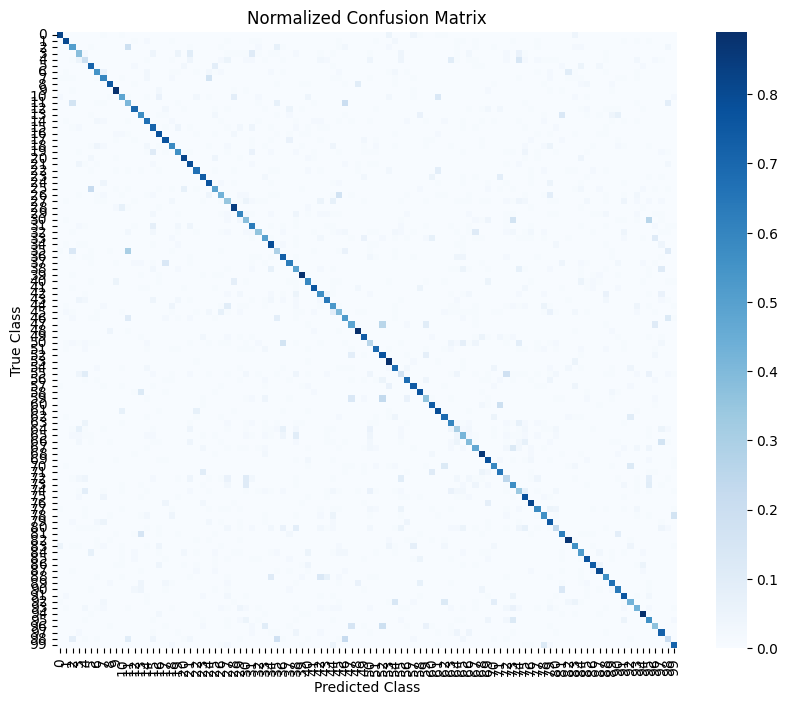

In [26]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, cmap='Blues', xticklabels=range(100), yticklabels=range(100))
plt.title('Normalized Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step


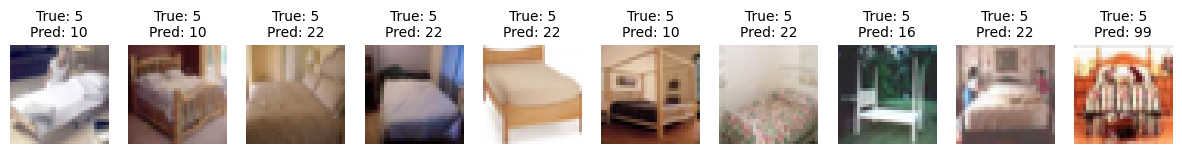

In [24]:
import matplotlib.pyplot as plt
import numpy as np

def show_images_in_class(class_index, num_images=10, predictions=None):
    """
    Displays images belonging to a specific class along with their predicted labels.

    Args:
        class_index: The index of the true class to display.
        num_images: The maximum number of images to display.
        predictions: Model predictions (optional). If provided, the predicted labels will be displayed.
    """
    # Find indices of images belonging to the specified class
    true_indices = np.where(np.argmax(y_test, axis=1) == class_index)[0]

    # Determine the number of images to display
    num_images_to_display = min(num_images, len(true_indices))

    plt.figure(figsize=(15, 5))

    for i in range(num_images_to_display):
        idx = true_indices[i]
        true_label = class_index
        predicted_label = None

        # Get predicted label if predictions are provided
        if predictions is not None:
            predicted_label = np.argmax(predictions[idx])

        # Plot the image
        plt.subplot(1, num_images_to_display, i + 1)
        plt.imshow(x_test[idx])
        title = f"True: {true_label}"
        if predicted_label is not None:
            title += f"\nPred: {predicted_label}"
        plt.title(title, fontsize=10)
        plt.axis('off')

    plt.show()

# Example usage
predictions = model.predict(x_test / 255.0)  # Normalize x_test before prediction
show_images_in_class(class_index=5, num_images=10, predictions=predictions)
